# Train- Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms


## Train and Validation Dataset

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
# /content/gdrive/MyDrive/Colab Notebooks/Dataset/Processed.zip

In [4]:
!unzip -q -o /content/gdrive/MyDrive/Colab\ Notebooks/Dataset/Processed.zip -d datasets


#### Loading npy files

In [5]:
def load_file(path):
  return np.load(path).astype(np.float32)

In [6]:
train_transforms = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248),
    transforms.RandomAffine(degrees=(-5,5), translate=(0, 0.05), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop((224,224), scale=(0.35, 1))
])

In [7]:
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248)
])

In [8]:
train_dataset = torchvision.datasets.DatasetFolder("/content/datasets/train/", loader=load_file, extensions="npy", transform=train_transforms)

In [9]:
val_dataset = torchvision.datasets.DatasetFolder("/content/datasets/val/", loader=load_file, extensions="npy", transform=val_transforms)

In [10]:
type(train_dataset)

torchvision.datasets.folder.DatasetFolder

### Display Images

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


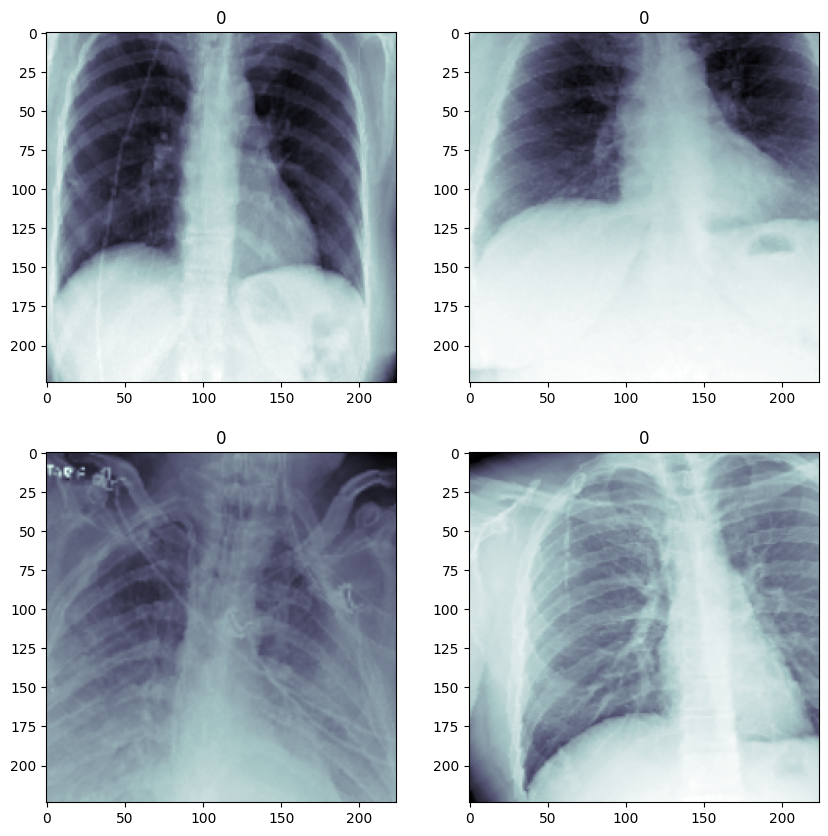

In [11]:
fig, axis = plt.subplots(2,2, figsize=(10,10))

for row in range(2):
  for column in range(2):
    random_index = np.random.randint(0,24000)
    x_ray, label = train_dataset[random_index]    # tuple unpacking
    axis[row][column].imshow(x_ray[0,:,:], cmap="bone")
    axis[row][column].set_title(label)


### Data Loader

In [12]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [13]:
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([18593,  5407]))

# Define Model

In [16]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
# Change Input and Output shape

class PneumoniaModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.model = torchvision.models.resnet18()
    self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3, 3), bias=False)
    self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)

    # Optimizer and Loss
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
    self.loss_fn = torch.nn.BCELoss()

    # Trackers
    self.train_losses = []
    self.test_losses = []
    self.train_correct = []
    self.test_correct = []

  def forward(self, X):
    pred = self.model(X)
    return pred

In [23]:
model = PneumoniaModel()

In [24]:
model

PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac